# 13: Hail Average Magnitude Forecast | Region: U.S. Mainland
---

## 1. Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime

pd.set_option('display.max_columns', None)

---
## 2. Loading Data

In [2]:
all_storms = pd.read_csv('../data/all_storms_dt_damage_clean.csv')

/Applications/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


---
## 3. Organizing Data

### 3.1. Dropping Columns

In [3]:
all_storms = all_storms[['state', 'region', 'event_type', 'begin_date_time', 'magnitude']]

In [4]:
all_storms

,state,region,event_type,begin_date_time,magnitude
0,Oklahoma,South,Tornado,1950-04-28 14:45:00,0.0
1,Texas,South,Tornado,1950-06-19 20:40:00,0.0
2,Indiana,Midwest,Tornado,1950-07-19 14:30:00,0.0
3,Indiana,Midwest,Tornado,1950-07-19 17:45:00,0.0
4,Colorado,West,Tornado,1950-07-22 15:07:00,0.0
...,...,...,...,...,...
1740591,Arkansas,South,Winter Storm,2022-02-02 18:45:00,NaN
1740592,Arkansas,South,Winter Weather,2022-02-03 02:50:00,NaN
1740593,Arkansas,South,Winter Storm,2022-02-03 01:00:00,NaN
1740594,Massachusetts,Northeast,Heavy Snow,2022-02-25 00:00:00,NaN


In [5]:
# Casting the begin_date_time to a datetime dtype
all_storms['begin_date_time'] = pd.to_datetime(all_storms['begin_date_time'])

# Setting begin_date_time as the index
all_storms.set_index('begin_date_time', inplace=True)

# Sorting the index
all_storms.sort_index(inplace=True)

In [6]:
# Dropping all rows with a missing value in the magnitude column

all_storms = all_storms.dropna(subset=['magnitude'])

### 3.2. Subsetting to Hail in all U.S. mainland regions (2000-2022)

In [10]:
hail = all_storms[all_storms['event_type'] == 'Hail']

hail = hail[hail['region'].isin(['Midwest', 'South', 'Northeast', 'West'])]

hail = hail[hail.index > '2000']

In [11]:
hail

,state,region,event_type,magnitude
begin_date_time,,,,
2000-01-03 00:12:00,Arkansas,South,Hail,0.75
2000-01-03 00:25:00,Texas,South,Hail,1.00
2000-01-03 01:50:00,Oklahoma,South,Hail,1.00
2000-01-03 02:55:00,Arkansas,South,Hail,0.88
2000-01-03 03:00:00,Missouri,Midwest,Hail,0.88
...,...,...,...,...
2022-03-31 14:17:00,West Virginia,South,Hail,1.00
2022-03-31 15:39:00,West Virginia,South,Hail,1.00
2022-03-31 15:42:00,West Virginia,South,Hail,1.00


### 3.3. Resampling to Quarterly Averages

In [12]:
# Helper plotting function

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
   
    plt.figure(figsize=(10,6))
    
    for col in cols:
        plt.plot(df[col])

    plt.title(title, fontsize=14)
    plt.xlabel(xlab, fontsize=12)
    plt.ylabel(ylab, fontsize=12)
    
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12);

In [13]:
# Resampling to quarterly averages
hail = hail.resample('Q').mean()

# Renaming the column to 'avg_mag'
hail = hail.rename(columns={'magnitude': 'avg_mag'})

In [14]:
# Checking for null values as a result of the resampling

hail.isnull().sum()

avg_mag    0
dtype: int64

In [15]:
hail

,avg_mag
begin_date_time,
2000-03-31,1.090237
2000-06-30,1.104432
2000-09-30,1.085179
2000-12-31,0.996006
2001-03-31,0.957717
...,...
2021-03-31,1.181418
2021-06-30,1.300239
2021-09-30,1.270510


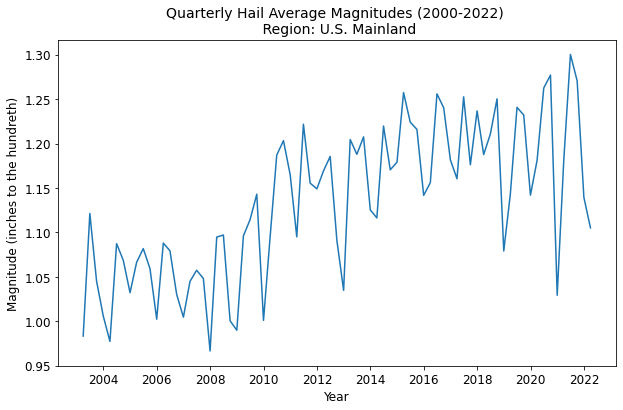

In [63]:
# Quarterly Hail Average Magnitudes (2000-2022) - Region: U.S. Mainland

plot_series(hail, ['avg_mag'], title='Quarterly Hail Average Magnitudes (2000-2022) \n Region: U.S. Mainland', xlab='Year', ylab='Magnitude (inches to the hundreth)', steps=4)

---
## 4. Trends

### 4.1. Seasonality

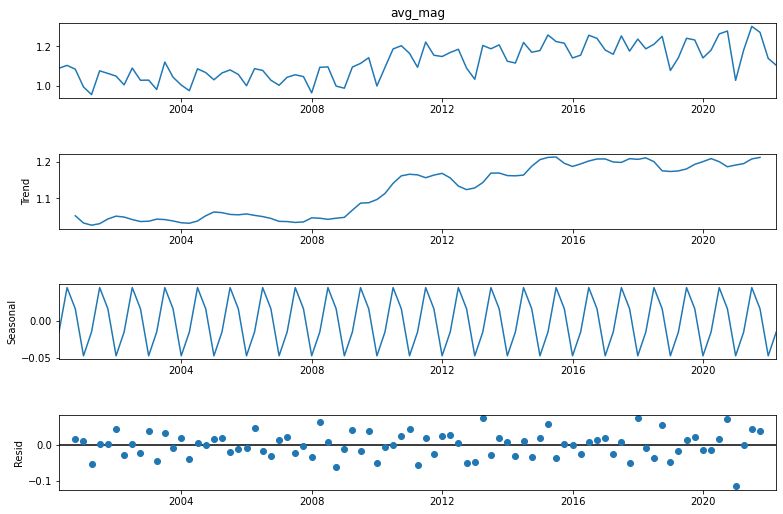

In [17]:
decomp = seasonal_decompose(hail['avg_mag'])

decomp.plot();
fig = plt.gcf()
fig.set_size_inches(12, 8)

In the trend component, we see an increasing trend.

In the seasonal component, we see that there appears to be some seasonality detected. But this seasonal view can sometimes be miselading, so I'll need to run some additional diagnostics.

In the resid component, we see that there's quite a bit of variability that can not be explained by the model.

### 4.2. Autocorrelation

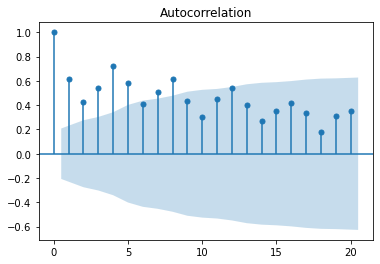

In [18]:
plot_acf(hail['avg_mag']);

For trend, the first 5 lags all extend beyond the blue region, which represents a 95% confidence interval. This confirms that there is a trend present in the data.

For seasonality, the fluctuations do seem to occur with a fixed and known frequency and therefore, indicates that there may be seasonality present in the data.

For lags, it seems that the first 5 lags will be useful to include in the model.

### 4.3. Partial Autocorrelation

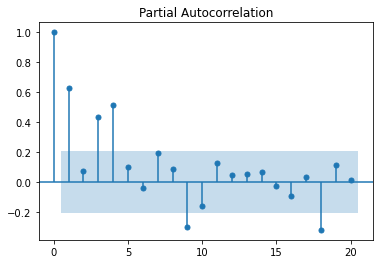

In [19]:
plot_pacf(hail['avg_mag']);

For seasonality, contrary to the autocorrelation, the fluctuations no longer occur with a fixed and known frequency and therefore, determines that there is no seasonality present.

For lags, it still seems that the first lag will be useful to include in the model.

### 4.4. Stationarity

In [20]:
# Dickey-Fuller Stationarity Test

adfuller(hail['avg_mag'])

(-0.9068763864107859,
 0.7856994908764637,
 10,
 78,
 {'1%': -3.517113604831504,
  '5%': -2.8993754262546574,
  '10%': -2.5869547797501644},
 -234.1700770268517)

The first 2 statistics of the test results tell me that the data is not stationary.

The 'test statistic', the first statistic, needs to be less than the critical values, which are the 1%, 5% and 10% values, and it is not. The p-value, the second statistic, needs to be less than the alpha of 0.05, and it is not. As a result, I'll need to difference the data.

### 4.5. Differencing

#### 4.5.1. Once Differenced

In [21]:
# Differencing the data

hail['first_diff'] = hail['avg_mag'].diff()

In [22]:
# Dropping any null values as a result of the differencing

hail.dropna(inplace=True)

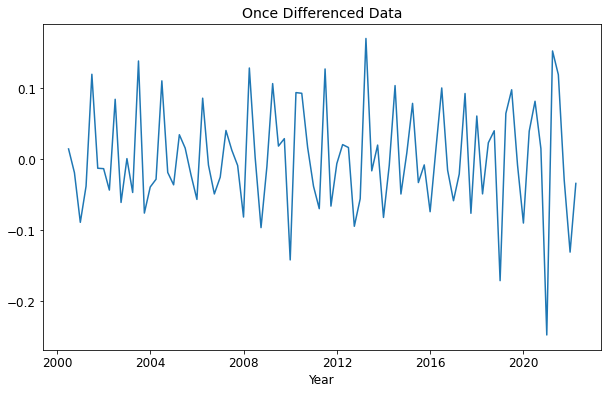

In [23]:
plot_series(hail, ['first_diff'], title='Once Differenced Data', xlab='Year', steps=4)

In [24]:
# Checking for the stationarity of the once differenced data

adfuller(hail['first_diff'])

(-3.097582900341819,
 0.026732582561638116,
 9,
 78,
 {'1%': -3.517113604831504,
  '5%': -2.8993754262546574,
  '10%': -2.5869547797501644},
 -230.88868977825393)

Though the p-value is less than the alpha of 0.05, the test statistic is not smaller than the 1% critical value. I'll need to difference once more in order to make the data stationary.

#### 4.5.2. Twice Differenced

In [41]:
# Differencing the data

hail['second_diff'] = hail['avg_mag'].diff().diff()

In [42]:
# Dropping any null values as a result of the differencing

hail.dropna(inplace=True)

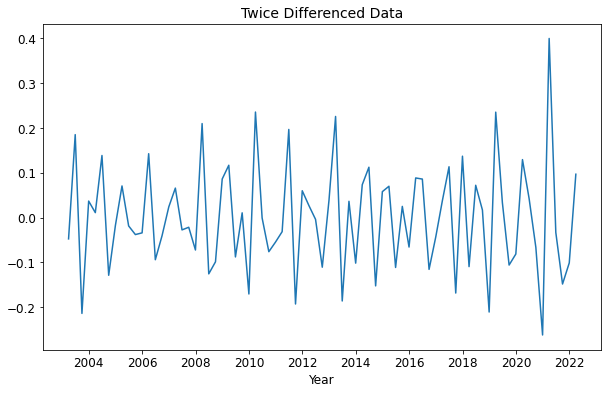

In [43]:
plot_series(hail, ['second_diff'], title='Twice Differenced Data', xlab='Year', steps=4)

In [44]:
# Checking for the stationarity of the once differenced data

adfuller(hail['second_diff'])

(-8.140786037466864,
 1.0295456145842953e-12,
 7,
 69,
 {'1%': -3.528889992207215,
  '5%': -2.9044395987933362,
  '10%': -2.589655654274312},
 -182.67878517076912)

The test statistic is now less than the critical values and the p-value is less than the alpha of 0.05. The data is now stationary and can be modeled on with ARIMA.

---
## 5. ARIMA Time Series Modeling

### 5.1. Train-Test Split

In [45]:
y_train, y_test = train_test_split(hail['second_diff'], test_size=0.1, shuffle=False)

### 5.2. GridSearch for best AIC, p & q

Because I needed to difference the data twice, I know that the d parameter for the ARIMA model is 2. Given that, I'll run a GridSearch for the most optimal p & q.

In [46]:
best_aic = 1_000_000_000
best_p = 0
best_q = 0

for p in range(5):
    for q in range(5):

        try:
            
            arima = ARIMA(endog = y_train.astype(float).dropna(),
                         order=(p, 2, q))
            
            model = arima.fit(method_kwargs={"warn_convergence": False})

            print(f'The AIC for ARIMA({p},2,{q}) is: {model.aic}')

            if model.aic < best_aic:
                best_aic = model.aic
                best_p = p
                best_q = q

        except Exception as e:
            print(e)
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},2,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

The AIC for ARIMA(0,2,0) is: 49.84097346669953
The AIC for ARIMA(0,2,1) is: -21.028434987703026
The AIC for ARIMA(0,2,2) is: -83.0829779744127


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(0,2,3) is: -132.6323626682362
The AIC for ARIMA(0,2,4) is: -151.53626117200415
The AIC for ARIMA(1,2,0) is: 5.708090813419524
The AIC for ARIMA(1,2,1) is: -48.94813223221933
The AIC for ARIMA(1,2,2) is: -96.50893076932817
The AIC for ARIMA(1,2,3) is: -79.69473090202992
The AIC for ARIMA(1,2,4) is: -129.84235497175283
The AIC for ARIMA(2,2,0) is: -14.087823997115382
The AIC for ARIMA(2,2,1) is: -64.77264222702021
The AIC for ARIMA(2,2,2) is: -110.73573736886244
The AIC for ARIMA(2,2,3) is: -95.2587792633029
The AIC for ARIMA(2,2,4) is: -81.94482451547557
The AIC for ARIMA(3,2,0) is: -33.38475291356287
The AIC for ARIMA(3,2,1) is: -86.40050224697653
The AIC for ARIMA(3,2,2) is: -132.49128259047995
The AIC for ARIMA(3,2,3) is: -107.37099881074063
The AIC for ARIMA(3,2,4) is: -94.20597638326463
The AIC for ARIMA(4,2,0) is: -74.5725585692441


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


The AIC for ARIMA(4,2,1) is: -120.09640106681906
The AIC for ARIMA(4,2,2) is: -150.88252262471798
The AIC for ARIMA(4,2,3) is: -146.09246574125353
The AIC for ARIMA(4,2,4) is: -159.08136129771367


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(4,2,4).
This model has an AIC of -159.08136129771367.


The p, d, q combination that returned the lowest AIC was when p=4, d=2, and q=4. This means that the model will perform best with the use of 4 lags, twice differenced data, and a moving average window of 4. As such, the order of (4,2,4) will be used in the ARIMA model.

### 5.3. Instantiate & Fit

In [47]:
model = ARIMA(endog=y_train.astype(float).dropna(), order = (4,2,4))

arima = model.fit()

/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 5.4. Test Forecast

In [48]:
# Checking how many quarters were considered as test data with a test size of 10%

len(y_test)

8

In [49]:
# Generating the forecast for those 8 quarters

forecast = arima.forecast(steps=8)
forecast

2020-06-30   -0.005091
2020-09-30   -0.059988
2020-12-31   -0.005807
2021-03-31    0.026497
2021-06-30    0.033932
2021-09-30   -0.054905
2021-12-31    0.013674
2022-03-31   -0.004242
Freq: Q-DEC, Name: predicted_mean, dtype: float64

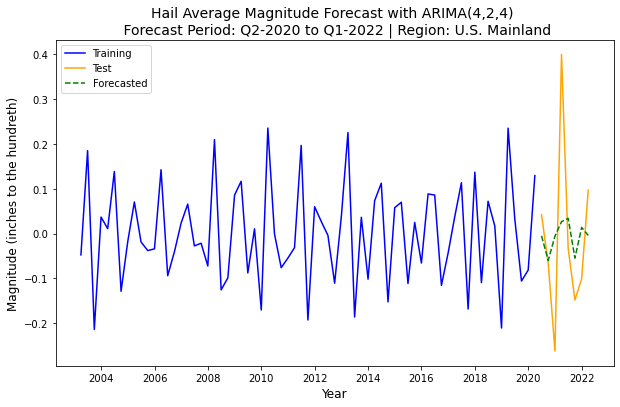

In [61]:
# Hail Average Magnitude Forecast with ARIMA(4,2,4) - Forecast Period: Q1-2020 to Q1-2022 | Region: U.S. Mainland

plt.figure(figsize=(10,6))
plt.plot(y_train.index, y_train, color='blue', label='Training')
plt.plot(y_test.index, y_test, color='orange', label='Test')
plt.plot(y_test.index, forecast, color='green', label='Forecasted', linestyle='--')

plt.title(label = 'Hail Average Magnitude Forecast with ARIMA(4,2,4) \n Forecast Period: Q2-2020 to Q1-2022 | Region: U.S. Mainland', fontsize=14)
plt.xlabel('Year',fontsize=12)
plt.ylabel('Magnitude (inches to the hundreth)', fontsize=12)

plt.legend();

Visually, the model does not seem to have forecasted very well. It attempts to follow the increases and the decreases, but hardly. Though, the variability seen in the test is unprecedented in the data.

### 5.5. Test Evaluation

In [51]:
r2 = r2_score(y_test, forecast)
print('R2: ' + str(r2))

R2: 0.11858710892619695


The model is able to explain 12% of the variability in the data.

In [54]:
rmse = mean_squared_error(y_test, forecast, squared=False)
print('RMSE: ' + str(rmse))

RMSE: 0.17477404027085275


In [55]:
hail.describe()

,avg_mag,first_diff,second_diff
count,77.000000,77.000000,77.000000
mean,1.133426,0.000970,-0.000454
std,0.085396,0.077793,0.122750
min,0.966436,-0.247816,-0.262371
25%,1.068387,-0.049115,-0.094262
50%,1.141872,-0.008582,-0.004103
75%,1.203230,0.040200,0.072072
max,1.300239,0.169791,0.400022


The RMSE of 0.17 exceeded the standard deviation of 0.12. This model's forecasts are not reliable by these evaluation metric's standards.

## 6. Hail Conclusion

At the national level, the model was able to explain 12% of the variability, and did not produce a reliable forecast according to the RMSE (0.17) and standard deviation (0.12) comparison. This indicates that there are high amounts of natural variability in the data, and it is difficult to forecast reliably at the national level.

The models were able to explain more of the data at the regional level, though, only the Midwest was able to produce a reliable forecast.

- **Midwest**
    - The model was able to explain 55% of the variability
    - Produced a reliable forecast, according to the RMSE (0.09) and standard deviation (0.12) comparison
- **South**
    - The model was able to explain 31% of the variability
    - Did not produce a reliable forecast, according to the RMSE (0.118) and standard deviation (0.114) comparison
- **Northeast**
    - The model was able to explain 21% of the variability
    - Did not produce a reliable forecast, according to the RMSE (0.16) and standard deviation (0.13) comparison
- **West**
    - The model was able to explain 58% of the variability
    - Did not produce a reliable forecast, according to the RMSE (0.33) and standard deviation (0.30) comparison